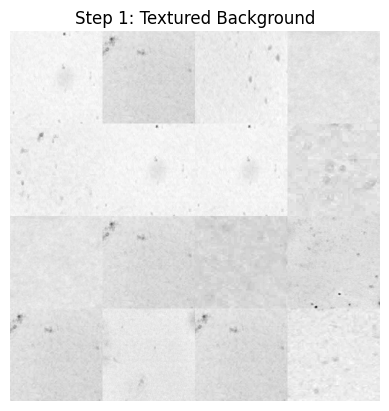

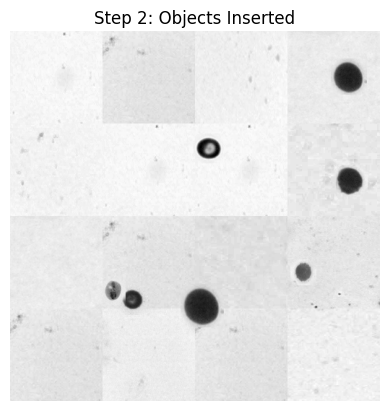

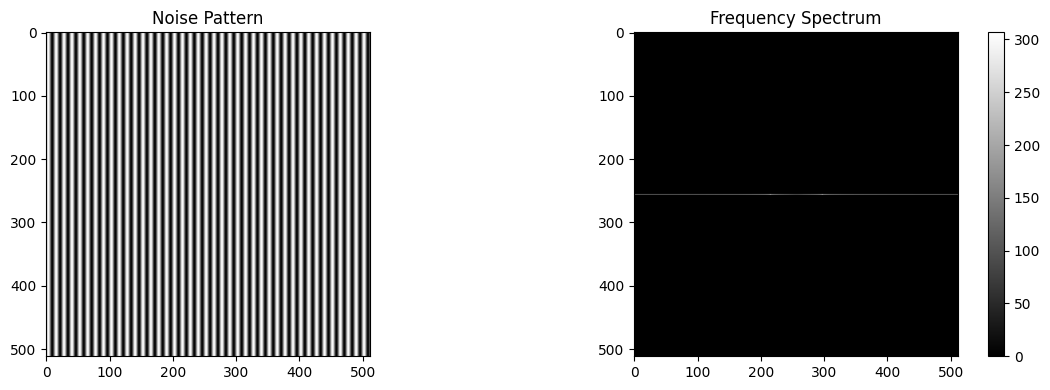

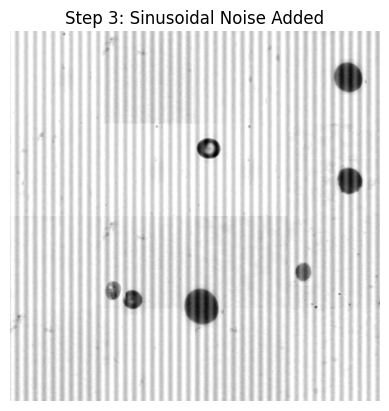

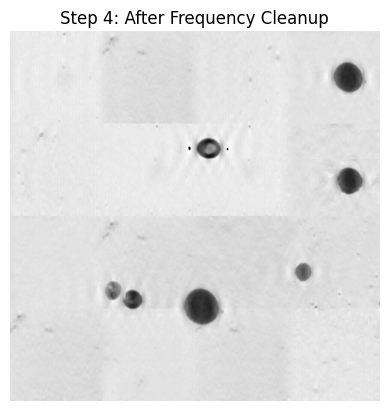

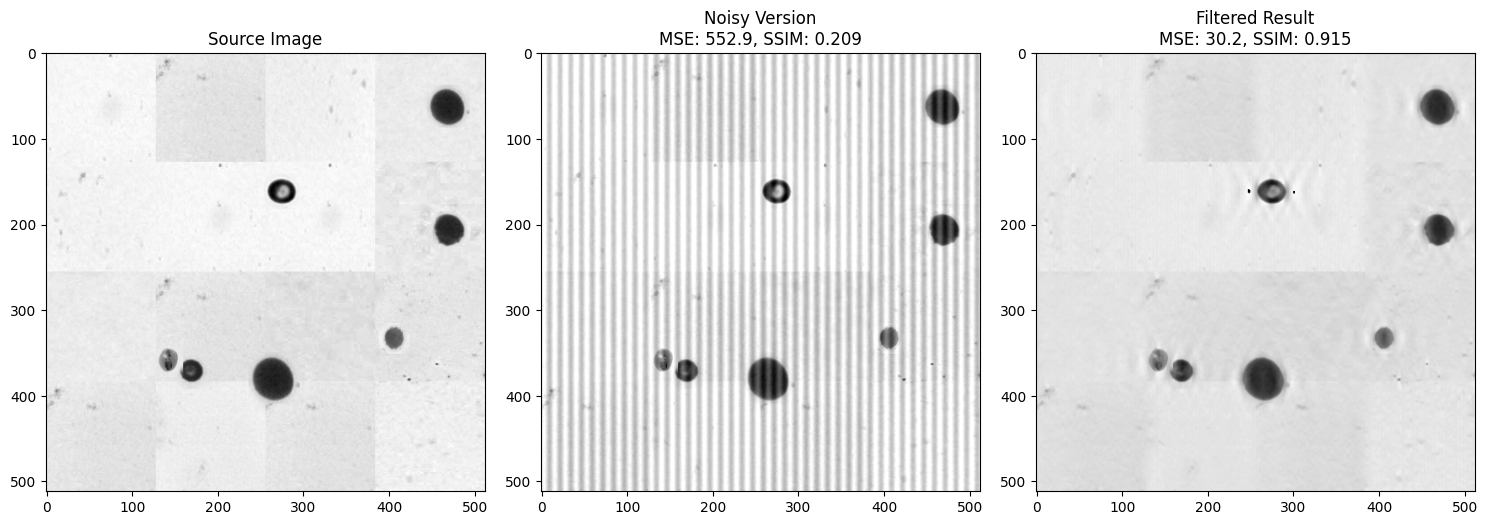

In [6]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity

def load_image_patches(directory_path):
    """Load grayscale image patches from specified directory"""
    image_extensions = ('.png', '.jpg', '.jpeg')
    loaded_patches = []
    
    for file in os.listdir(directory_path):
        if file.lower().endswith(image_extensions):
            try:
                img = cv2.imread(os.path.join(directory_path, file), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    loaded_patches.append(img)
            except Exception as e:
                print(f"Error loading {file}: {str(e)}")
    return loaded_patches

def create_textured_background(patch_collection, canvas_size=(512, 512)):
    """Generate tiled background from random patches"""
    background_image = np.zeros(canvas_size, dtype=np.uint8)
    tile_size = 128
    
    rows = canvas_size[0] // tile_size
    cols = canvas_size[1] // tile_size
    
    for row in range(rows):
        for col in range(cols):
            selected_patch = random.sample(patch_collection, 1)[0]
            resized_patch = cv2.resize(selected_patch, (tile_size, tile_size))
            y_start = row * tile_size
            y_end = y_start + tile_size
            x_start = col * tile_size
            x_end = x_start + tile_size
            background_image[y_start:y_end, x_start:x_end] = resized_patch
            
    return background_image

def insert_objects(base_image, object_collection, num_insertions=5):
    """Overlay objects with soft edges onto base image"""
    modified_image = base_image.copy()
    obj_size_range = (30, 70)
    
    for _ in range(num_insertions):
        # Randomly select and resize object
        obj_img = random.choice(object_collection)
        obj_size = random.randint(*obj_size_range)
        resized_obj = cv2.resize(obj_img, (obj_size, obj_size))
        
        # Generate blending mask
        mask = np.zeros((obj_size, obj_size), dtype=np.float32)
        cv2.circle(mask, (obj_size//2, obj_size//2), obj_size//2, 1.0, -1)
        mask = cv2.GaussianBlur(mask, (15, 15), 0)
        
        # Calculate random position with boundary check
        max_y = modified_image.shape[0] - obj_size
        max_x = modified_image.shape[1] - obj_size
        pos_y = random.randint(0, max_y)
        pos_x = random.randint(0, max_x)
        
        # Blend object into background
        region = modified_image[pos_y:pos_y+obj_size, pos_x:pos_x+obj_size]
        modified_image[pos_y:pos_y+obj_size, pos_x:pos_x+obj_size] = \
            (region * (1 - mask) + resized_obj * mask).astype(np.uint8)
    
    return modified_image

def apply_sinusoidal_interference(input_image, frequency=0.1, strength=30):
    """Add periodic wave pattern noise to image"""
    height, width = input_image.shape
    x_coords = np.linspace(0, width, width)
    y_coords = np.linspace(0, height, height)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    
    interference_pattern = strength * np.sin(2 * np.pi * frequency * grid_x)
    noisy_output = input_image.astype(np.float32) + interference_pattern
    
    # Visualize noise characteristics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(interference_pattern, cmap='gray')
    plt.title('Noise Pattern')

    spectrum = 20 * np.log(np.abs(np.fft.fftshift(np.fft.fft2(interference_pattern))) + 1)
    plt.subplot(1, 2, 2)
    plt.imshow(spectrum, cmap='gray')
    plt.title('Frequency Spectrum')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    return np.clip(noisy_output, 0, 255).astype(np.uint8)

def frequency_based_cleanup(noisy_image, target_frequency=0.1, filter_strength=20):
    """Remove periodic noise using frequency domain filtering with improved background restoration"""
    # Transform to frequency domain
    freq_domain = np.fft.fftshift(np.fft.fft2(noisy_image.astype(np.float32)))
    
    # Create notch filter mask
    rows, cols = noisy_image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.float32)
    
    # Calculate noise frequency position
    freq_spacing = int(target_frequency * cols)
    
    # Create multiple notch filters for harmonics
    for offset in [-2, -1, 1, 2]:  # Cover harmonics
        # Horizontal notch filter
        x_pos = ccol + offset * freq_spacing
        cv2.circle(mask, (x_pos, crow), filter_strength, 0, -1)
        
        # Vertical notch filter (optional, if vertical noise exists)
        # y_pos = crow + offset * freq_spacing
        # cv2.circle(mask, (ccol, y_pos), filter_strength, 0, -1)
    
    # Apply Gaussian blur to mask edges for smoother transition
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Apply mask and inverse transform
    filtered_freq = freq_domain * mask
    cleaned_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_freq)))
    
    # Post-processing to enhance background
    cleaned_image = cv2.medianBlur(cleaned_image.astype(np.uint8), 3)
    
    return np.clip(cleaned_image, 0, 255).astype(np.uint8)

def display_comparison(source, processed, restored):
    """Visual comparison with quality metrics"""
    noise_mse = mean_squared_error(source, processed)
    noise_ssim = structural_similarity(source, processed)
    clean_mse = mean_squared_error(source, restored)
    clean_ssim = structural_similarity(source, restored)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.imshow(source, cmap='gray'), plt.title('Source Image')
    plt.subplot(1, 3, 2), plt.imshow(processed, cmap='gray')
    plt.title(f'Noisy Version\nMSE: {noise_mse:.1f}, SSIM: {noise_ssim:.3f}')
    plt.subplot(1, 3, 3), plt.imshow(restored, cmap='gray')
    plt.title(f'Filtered Result\nMSE: {clean_mse:.1f}, SSIM: {clean_ssim:.3f}')
    plt.tight_layout(), plt.show()

if __name__ == "__main__":
    # Configuration parameters
    background_dir = '/Users/nident/Desktop/RSREU/МФТИ/2семак/blood_cells_dataset/fon'
    objects_dir = '/Users/nident/Desktop/RSREU/МФТИ/2семак/blood_cells_dataset/patch'
    
    # Load image components
    bg_patches = load_image_patches(background_dir)
    obj_patches = load_image_patches(objects_dir)
    
    # Step 1: Create base background
    base = create_textured_background(bg_patches)
    plt.figure()
    plt.imshow(base, cmap='gray')
    plt.title('Step 1: Textured Background')
    plt.axis('off')
    plt.show()
    
    # Step 2: Insert objects
    composite = insert_objects(base, obj_patches, num_insertions=7)
    plt.figure()
    plt.imshow(composite, cmap='gray')
    plt.title('Step 2: Objects Inserted')
    plt.axis('off')
    plt.show()
    
    # Step 3: Add interference
    noisy_composite = apply_sinusoidal_interference(composite, frequency=0.08, strength=35)
    plt.figure()
    plt.imshow(noisy_composite, cmap='gray')
    plt.title('Step 3: Sinusoidal Noise Added')
    plt.axis('off')
    plt.show()
    
    # Step 4: Filter and cleanup
    cleaned_image = frequency_based_cleanup(noisy_composite, target_frequency=0.08)
    plt.figure()
    plt.imshow(cleaned_image, cmap='gray')
    plt.title('Step 4: After Frequency Cleanup')
    plt.axis('off')
    plt.show()
    
    # Final Comparison
    display_comparison(composite, noisy_composite, cleaned_image)